<a href="https://colab.research.google.com/github/AshishRShetty/csce5218/blob/main/Advanced_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GROUP 22 ADVANCED MODEL ( MY MODEL )
## ASHISH RATHNAKAR SHETTY (11808466) SIDDHIVINAYAK RAGHAVRAJU ()


This project builds an advanced image captioning model using a ResNet101 encoder and a layer-normalized LSTM decoder with attention.
The Flickr30K dataset is used, and captions are generated with beam search decoding for higher quality.
Training uses scheduled sampling, gradient clipping, and mixed precision to improve performance and stability.
Evaluation metrics like BLEU, ROUGE-L, and METEOR are used to assess caption quality on the validation set.

Install Huggingface datasets library


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

You're directly loading the Flickr30K dataset from Hugging Face’s datasets library instead of using local files.

In [ ]:
from datasets import load_dataset

# Load Flickr30K dataset directly from Huggingface
dataset = load_dataset("nlphuji/flickr30k")


README.md:   0%|          | 0.00/641 [00:00<?, ?B/s]

flickr30k.py:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0003.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

0004.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

0005.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0006.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0007.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

0008.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

You're downloading the Flickr30K dataset and printing its structure to see what splits (like train, test, validation) and fields it contains.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("nlphuji/flickr30k")
print(dataset)



DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})


You're loading only the test split of the Flickr30K dataset and printing the first sample to check how the data looks.

In [ ]:
from datasets import load_dataset

dataset_dict = load_dataset("nlphuji/flickr30k")
dataset = dataset_dict['test']

# Example: Show 1 sample
print(dataset[0])


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x7A40B2386B10>, 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.'], 'sentids': ['0', '1', '2', '3', '4'], 'split': 'train', 'img_id': '0', 'filename': '1000092795.jpg'}


You're manually splitting the dataset into training and validation sets based on the 'split' field inside each sample.

In [ ]:
# Split into train and val
train_data = []
val_data = []

for sample in dataset:
    if sample['split'] == 'train':
        train_data.append(sample)
    elif sample['split'] == 'val':
        val_data.append(sample)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Train samples: 29000
Validation samples: 1014


You're creating a new dataset class that works with the Hugging Face-loaded Flickr30K data, randomly picking a caption for each image and applying transformations and tokenization.

In [ ]:
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import BertTokenizer

class Flickr30kDataset(Dataset):
    def __init__(self, data_list, tokenizer, transform=None, max_length=50):
        self.data_list = data_list
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample = self.data_list[idx]
        image = sample['image']
        captions = sample['caption']

        # Randomly pick one caption
        caption = random.choice(captions)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Tokenize the caption
        tokens = self.tokenizer.encode(caption,
                                       padding='max_length',
                                       truncation=True,
                                       max_length=self.max_length,
                                       return_tensors="pt").squeeze(0)
        return image, tokens


You're defining image preprocessing steps: resize, convert to tensor, and normalize for feeding images into the model.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


You're creating dataset objects and corresponding data loaders for the train and validation sets, ready to feed batches into the model during training.

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create Datasets
train_dataset = Flickr30kDataset(train_data, tokenizer, transform)
val_dataset = Flickr30kDataset(val_data, tokenizer, transform)

# Create DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


You're creating helper functions to decode tokenized captions and visualize a batch of images along with their corresponding captions.

In [ ]:
import matplotlib.pyplot as plt

# Function to decode token IDs back to text
def decode_tokens(tokenizer, token_ids):
    tokens = tokenizer.convert_ids_to_tokens(token_ids, skip_special_tokens=True)
    return tokenizer.convert_tokens_to_string(tokens)

# Function to visualize images and captions
def visualize_batch(dataloader, tokenizer, num_images=4):
    batch = next(iter(dataloader))
    images, captions = batch

    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        img = images[i].permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.clip(0, 1)

        caption_text = decode_tokens(tokenizer, captions[i])

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(caption_text, fontsize=8)

    plt.tight_layout()
    plt.show()


You're displaying a few training images along with their original captions to visually inspect if the dataset is loading correctly.

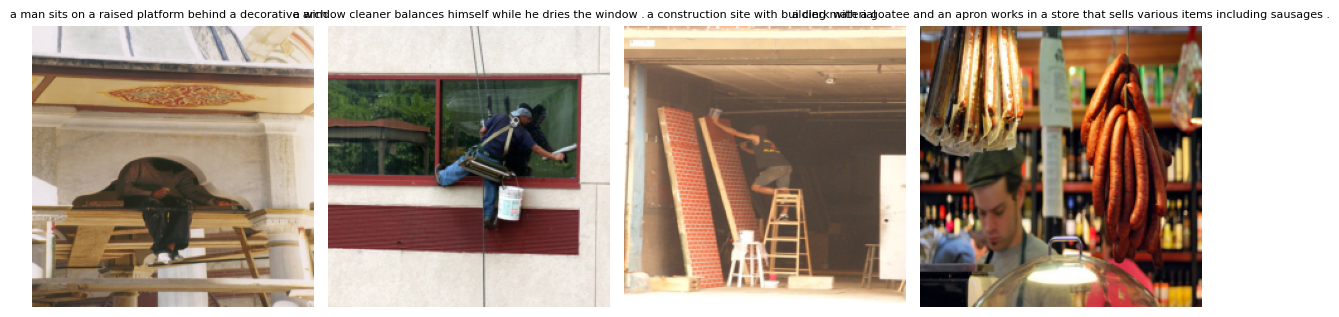

In [ ]:
visualize_batch(train_loader, tokenizer)


You're building a ResNet101-based encoder that extracts image features, reduces their size, and reshapes them for input into a decoder.

In [ ]:
import torchvision.models as models
import torch.nn as nn

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fc = nn.Linear(2048, 512)  # Reduce to 512-dim features

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))  # (batch, 196, 2048)
        features = self.fc(features)  # (batch, 196, 512)
        return features


You're creating an attention mechanism that learns to focus on the most relevant parts of the image features based on the decoder's current hidden state.

In [ ]:
class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.feature_attn = nn.Linear(feature_dim, attention_dim)
        self.hidden_attn = nn.Linear(hidden_dim, attention_dim)
        self.full_attn = nn.Linear(attention_dim, 1)

    def forward(self, features, hidden):
        att1 = self.feature_attn(features)
        att2 = self.hidden_attn(hidden).unsqueeze(1)
        att = torch.tanh(att1 + att2)
        alpha = torch.softmax(self.full_attn(att), dim=1)
        context = (features * alpha).sum(dim=1)
        return context, alpha.squeeze(2)


You're building an improved decoder with attention that uses a deeper LSTM, layer normalization, and gating mechanisms for better caption generation from image features.










In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoderWithAttentionV2(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, feature_dim=512, num_layers=2, dropout=0.3):
        super(DecoderWithAttentionV2, self).__init__()

        self.feature_dim = feature_dim
        self.decoder_dim = decoder_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.attention = Attention(feature_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_dim + feature_dim, decoder_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.layer_norm = nn.LayerNorm(decoder_dim)

        self.init_h = nn.Linear(feature_dim, decoder_dim)
        self.init_c = nn.Linear(feature_dim, decoder_dim)

        self.f_beta = nn.Linear(decoder_dim, feature_dim)
        self.sigmoid = nn.Sigmoid()

        self.init_weights()

    def decode_step(self, decoder_input, decoder_hidden):
        """
        Performs a single decoding step (LSTM cell and layer normalization).

        Args:
            decoder_input (torch.Tensor): Input to the LSTM cell.
            decoder_hidden (tuple): Hidden and cell states of the LSTM.

        Returns:
            tuple: Output of the LSTM cell and updated hidden/cell states.
        """
        output, (h_new, c_new) = self.lstm(decoder_input.unsqueeze(1), decoder_hidden)
        output = self.layer_norm(output.squeeze(1))
        return output, (h_new, c_new)

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        h = h.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = c.unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h, c

    def forward(self, encoder_out, captions, caption_lengths):
        batch_size = encoder_out.size(0)
        vocab_size = self.vocab_size

        embeddings = self.embedding(captions)

        h, c = self.init_hidden_state(encoder_out)

        decode_lengths = (caption_lengths - 1)
        max_decode_len = decode_lengths.max().item()

        predictions = torch.zeros(batch_size, max_decode_len, vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max_decode_len, encoder_out.size(1)).to(encoder_out.device)

        for t in range(max_decode_len):
            batch_size_t = sum([l > t for l in decode_lengths])

            context, alpha = self.attention(encoder_out[:batch_size_t], h[-1, :batch_size_t])

            gate = self.sigmoid(self.f_beta(h[-1, :batch_size_t]))
            context = gate * context

            lstm_input = torch.cat([embeddings[:batch_size_t, t, :], context], dim=1)

            h_t, (h_new, c_new) = self.lstm(lstm_input.unsqueeze(1), (h[:, :batch_size_t].contiguous(), c[:, :batch_size_t].contiguous()))
            h_t = h_t.squeeze(1)
            h_t = self.layer_norm(h_t)

            preds = self.fc(self.dropout(h_t))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

            h[:, :batch_size_t, :] = h_new
            c[:, :batch_size_t, :] = c_new

        return predictions, decode_lengths, alphas



You're setting up your code to automatically use a GPU if available, otherwise fall back to CPU.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


You're initializing your encoder and decoder models and moving them onto the selected device (GPU or CPU).

In [ ]:
encoder = EncoderCNN().to(device)
decoder = DecoderWithAttention(
    attention_dim=512,
    embed_dim=256,
    decoder_dim=512,
    vocab_size=tokenizer.vocab_size,
    feature_dim=512
).to(device)


You're setting up the loss function, a better optimizer (AdamW), and enabling mixed precision training to make your model faster and more memory efficient.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

# ⚡ Loss Function
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# ⚡ Optimizer (AdamW is better for transformers)
optimizer = optim.AdamW(
    list(decoder.parameters()) + list(encoder.fc.parameters()),  # Only train encoder's FC + decoder
    lr=1e-4
)

# ⚡ Mixed Precision
scaler = GradScaler()

print("✅ Loss, Optimizer, and AMP Scaler ready!")


✅ Loss, Optimizer, and AMP Scaler ready!


<ipython-input-77-2c0b1e459f45>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


You're training the encoder-decoder model for up to 100 epochs with scheduled sampling and gradient clipping to stabilize learning.
Mixed precision is used for faster training, and after every epoch, the model's checkpoint is saved.
Although training was planned for 100 epochs, you stopped at epoch 50 because the loss had plateaued, meaning further training wasn't improving the model anymore.
This helped save time and avoid overfitting!



In [ ]:
import random
import torch
import os

# Scheduled Sampling setup
scheduled_sampling_start = 5
scheduled_sampling_increase = 0.05
scheduled_sampling_max = 0.25

# Training Config
num_epochs = 100
clip_grad = 5.0  # gradient clipping
save_dir = "/content/checkpoints"   # ✅ Folder to save model checkpoints
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    epoch_loss = 0
    scheduled_sampling_prob = min(
        scheduled_sampling_max,
        scheduled_sampling_increase * max(0, epoch - scheduled_sampling_start)
    )

    for images, captions in train_loader:
        images, captions = images.to(device), captions.to(device)

        optimizer.zero_grad()

        with autocast(enabled=True):
            encoder_out = encoder(images)
            caption_lengths = (captions != tokenizer.pad_token_id).sum(dim=1)

            outputs, decode_lengths, alphas = decoder(encoder_out, captions, caption_lengths)

            batch_size, max_decode_len, vocab_size = outputs.shape

            outputs = outputs[:, :max(decode_lengths), :].reshape(-1, vocab_size)
            targets = captions[:, 1:][:, :max(decode_lengths)].reshape(-1)

            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip_grad)
        torch.nn.utils.clip_grad_norm_(encoder.fc.parameters(), clip_grad)

        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"✅ Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Scheduled Sampling: {scheduled_sampling_prob:.2f}")

    # ✅ Save checkpoint after every epoch
    checkpoint = {
        'epoch': epoch + 1,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': avg_loss
    }
    torch.save(checkpoint, os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth"))

    print(f"📦 Saved checkpoint for epoch {epoch+1}!")



<ipython-input-25-d53242db5a31>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


✅ Epoch [1/100], Loss: 7.3130, Scheduled Sampling: 0.00
📦 Saved checkpoint for epoch 1!
✅ Epoch [2/100], Loss: 6.4529, Scheduled Sampling: 0.00
📦 Saved checkpoint for epoch 2!
✅ Epoch [3/100], Loss: 6.1641, Scheduled Sampling: 0.00
📦 Saved checkpoint for epoch 3!
✅ Epoch [4/100], Loss: 5.9791, Scheduled Sampling: 0.00
📦 Saved checkpoint for epoch 4!
✅ Epoch [5/100], Loss: 5.8217, Scheduled Sampling: 0.00
📦 Saved checkpoint for epoch 5!
✅ Epoch [6/100], Loss: 5.7450, Scheduled Sampling: 0.00
📦 Saved checkpoint for epoch 6!
✅ Epoch [7/100], Loss: 5.6898, Scheduled Sampling: 0.05
📦 Saved checkpoint for epoch 7!
✅ Epoch [8/100], Loss: 5.6200, Scheduled Sampling: 0.10
📦 Saved checkpoint for epoch 8!
✅ Epoch [9/100], Loss: 5.5736, Scheduled Sampling: 0.15
📦 Saved checkpoint for epoch 9!
✅ Epoch [10/100], Loss: 5.5254, Scheduled Sampling: 0.20
📦 Saved checkpoint for epoch 10!
✅ Epoch [11/100], Loss: 5.4927, Scheduled Sampling: 0.25
📦 Saved checkpoint for epoch 11!
✅ Epoch [12/100], Loss: 5.47

KeyboardInterrupt: 

You're loading the saved checkpoint from epoch 50 and printing its keys to see what components (like model weights, optimizer state, etc.) were stored.

In [ ]:
checkpoint = torch.load('/content/checkpoints/checkpoint_epoch_50.pth', map_location=device)
print(checkpoint.keys())


dict_keys(['epoch', 'encoder_state_dict', 'decoder_state_dict', 'optimizer_state_dict', 'scaler_state_dict', 'loss'])


You're restoring the trained encoder and decoder weights from the saved checkpoint so you can continue using the model without retraining.

In [ ]:
# Load checkpoint
checkpoint = torch.load('/content/checkpoints/checkpoint_epoch_50.pth', map_location=device)

# Load model weights
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# If you also want to optionally load optimizer/scaler states:
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scaler.load_state_dict(checkpoint['scaler_state_dict'])

print("✅ Successfully loaded encoder and decoder from checkpoint!")


✅ Successfully loaded encoder and decoder from checkpoint!


You're moving the models to the correct device and setting them to evaluation mode, which disables dropout and other training-specific behaviors.

In [ ]:
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()


You're defining a beam search function that generates more accurate and diverse captions by exploring multiple word paths at each decoding step instead of just picking the top word every time.

In [ ]:
# 🔥 Beam Search Caption Generation
def generate_caption_beam(encoder, decoder, image, tokenizer, device, beam_size=5, max_len=50):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoder_out = encoder(image.unsqueeze(0).to(device))
        enc_image_size = encoder_out.size(1)
        encoder_out = encoder_out.expand(beam_size, enc_image_size, encoder_out.size(-1))

        k_prev_words = torch.LongTensor([[tokenizer.cls_token_id]] * beam_size).to(device)
        seqs = k_prev_words
        top_k_scores = torch.zeros(beam_size, 1).to(device)

        complete_seqs = []
        complete_seqs_scores = []

        h, c = decoder.init_hidden_state(encoder_out)

        step = 0
        while True:
            embeddings = decoder.embedding(k_prev_words).squeeze(1)
            awe, _ = decoder.attention(encoder_out, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))

            scores = decoder.fc(h)
            scores = torch.log_softmax(scores, dim=1)

            scores = top_k_scores.expand_as(scores) + scores

            if step == 0:
                top_k_scores, top_k_words = scores[0].topk(beam_size, 0, True, True)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(beam_size, 0, True, True)

            prev_word_inds = top_k_words // tokenizer.vocab_size
            next_word_inds = top_k_words % tokenizer.vocab_size

            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)

            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != tokenizer.sep_token_id]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])

            beam_size = len(incomplete_inds)
            if beam_size == 0:
                break

            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)

            step += 1
            if step > max_len:
                break

        if len(complete_seqs_scores) == 0:
            complete_seqs = seqs
            complete_seqs_scores = top_k_scores.squeeze(1)

        i = torch.argmax(torch.stack(list(complete_seqs_scores))).item()
        seq = complete_seqs[i]

    caption = tokenizer.decode(seq, skip_special_tokens=True)
    return caption



You're evaluating your model on a batch of validation images, generating captions with beam search, and computing multiple quality metrics — BLEU-1 to BLEU-4, ROUGE-L, and METEOR — to get a full picture of how well your captions match the ground truth.

In [ ]:
def full_evaluate(encoder, decoder, val_loader, tokenizer, device, num_samples=200):
    encoder.eval()
    decoder.eval()

    smooth = SmoothingFunction().method1

    all_references = []
    all_hypotheses = []

    total_bleu1 = []
    total_bleu2 = []
    total_bleu3 = []
    total_bleu4 = []
    total_meteor = []

    with torch.no_grad():
        for i, (images, captions) in enumerate(val_loader):
            if i * images.size(0) >= num_samples:
                break

            images = images.to(device)
            captions = captions.to(device)

            for idx in range(images.size(0)):
                image = images[idx]
                gt_tokens = captions[idx]

                reference_text = tokenizer.decode(gt_tokens, skip_special_tokens=True)
                reference = reference_text.lower().strip()

                pred_text = generate_caption_beam(encoder, decoder, image, tokenizer, device)

                reference_tokens = reference.split()
                pred_tokens = pred_text.split()

                # BLEU
                total_bleu1.append(sentence_bleu([reference_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth))
                total_bleu2.append(sentence_bleu([reference_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth))
                total_bleu3.append(sentence_bleu([reference_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth))
                total_bleu4.append(sentence_bleu([reference_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))

                # METEOR (✅ fixed to pass token lists)
                total_meteor.append(meteor_score([reference_tokens], pred_tokens))

                all_references.append(reference)
                all_hypotheses.append(pred_text)

    # ROUGE
    rouge_scores = rouge.compute(predictions=all_hypotheses, references=all_references)
    rougeL_score = rouge_scores['rougeL']

    print(f"✅ BLEU-1: {np.mean(total_bleu1):.4f}")
    print(f"✅ BLEU-2: {np.mean(total_bleu2):.4f}")
    print(f"✅ BLEU-3: {np.mean(total_bleu3):.4f}")
    print(f"✅ BLEU-4: {np.mean(total_bleu4):.4f}")
    print(f"✅ ROUGE-L: {rougeL_score:.4f}")
    print(f"✅ METEOR: {np.mean(total_meteor):.4f}")


You're installing the rouge-score library so you can calculate ROUGE metrics during caption evaluation.

In [ ]:
!pip install rouge-score

You're installing the evaluate library quietly (without showing extra logs) to compute evaluation metrics like ROUGE easily.

In [ ]:
!pip install evaluate --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


You're downloading essential NLTK resources to properly calculate METEOR scores, which rely on word meaning and synonyms.

In [ ]:
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # (optional but recommended for full word mappings)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Load ROUGE scoring module and evaluate model on 1000 samples from validation set.

In [ ]:
import evaluate

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Now run full evaluation
full_evaluate(encoder, decoder, val_loader, tokenizer, device, num_samples=1000)


✅ BLEU-1: 0.2370
✅ BLEU-2: 0.1244
✅ BLEU-3: 0.0759
✅ BLEU-4: 0.0516
✅ ROUGE-L: 0.2796
✅ METEOR: 0.2053


You're storing the training loss for each epoch into a list so you can later plot it or analyze how the model's loss decreased over the 50 epochs.

In [ ]:

losses_per_epoch = [
    7.3130, 6.4529, 6.1641, 5.9791, 5.8217, 5.7450, 5.6898, 5.6200, 5.5736, 5.5254,
    5.4927, 5.4759, 5.4474, 5.4211, 5.4056, 5.3864, 5.3699, 5.3520, 5.3474, 5.3457,
    5.3223, 5.3182, 5.3056, 5.2990, 5.2975, 5.2595, 5.2654, 5.2421, 5.2320, 5.2378,
    5.2382, 5.2235, 5.2167, 5.1988, 5.1863, 5.1815, 5.1789, 5.1720, 5.1686, 5.1500,
    5.1536, 5.1387, 5.1395, 5.1181, 5.1241, 5.1048, 5.0921, 5.0949, 5.0830, 5.0917
]



You're creating a smooth, beautiful curve to visualize how your training loss decreased over epochs, making it easier to see trends compared to raw points.

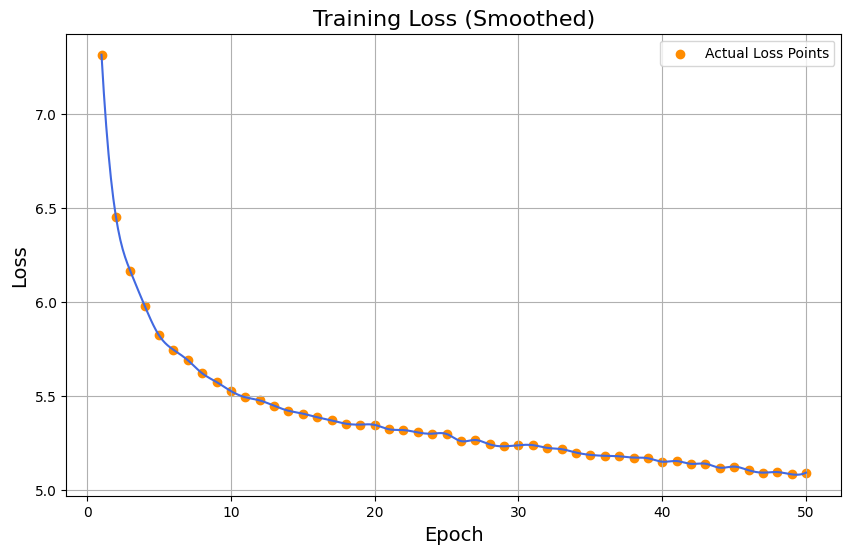

In [ ]:
from scipy.interpolate import make_interp_spline
import numpy as np

x = np.array(range(1, len(losses_per_epoch) + 1))
y = np.array(losses_per_epoch)

# Smooth points
xnew = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)  # B-spline
y_smooth = spl(xnew)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(xnew, y_smooth, color='royalblue')
plt.scatter(x, y, color='darkorange', label="Actual Loss Points")
plt.title('Training Loss (Smoothed)', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


You're defining a function that randomly picks an image from the dataloader, shows the image, and neatly displays both the ground truth and the model's predicted caption in different colors.

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

def visualize_random_prediction_color(encoder, decoder, dataloader, tokenizer, device):
    encoder.eval()
    decoder.eval()

    batch = next(iter(dataloader))
    images, captions = batch

    # 🎯 Randomly pick an image in the batch
    idx = random.randint(0, images.size(0) - 1)
    img = images[idx].to(device)
    gt_caption_tokens = captions[idx]

    # 1. Generate prediction
    generated_caption = generate_caption_beam(
        encoder, decoder, img, tokenizer, device, beam_size=5
    )

    # 2. Decode ground truth
    gt_caption = tokenizer.decode(gt_caption_tokens, skip_special_tokens=True)

    # 3. Prepare image (unnormalize)
    img_display = img.cpu().permute(1, 2, 0)
    img_display = img_display * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img_display = img_display.clip(0, 1)

    # 4. Plot image
    plt.figure(figsize=(10, 8))
    plt.imshow(img_display)
    plt.axis('off')

    # 5. Add color-coded captions
    plt.text(
        0, img_display.shape[0] + 10,
        f"Ground Truth: {gt_caption}",
        fontsize=12,
        color='blue',
        wrap=True
    )
    plt.text(
        0, img_display.shape[0] + 50,
        f"Predicted: {generated_caption}",
        fontsize=12,
        color='green',
        wrap=True
    )

    plt.tight_layout()
    plt.show()




You're running the function to visually compare the model's predicted caption and the actual caption for a random validation image — all nicely plotted with color coding.

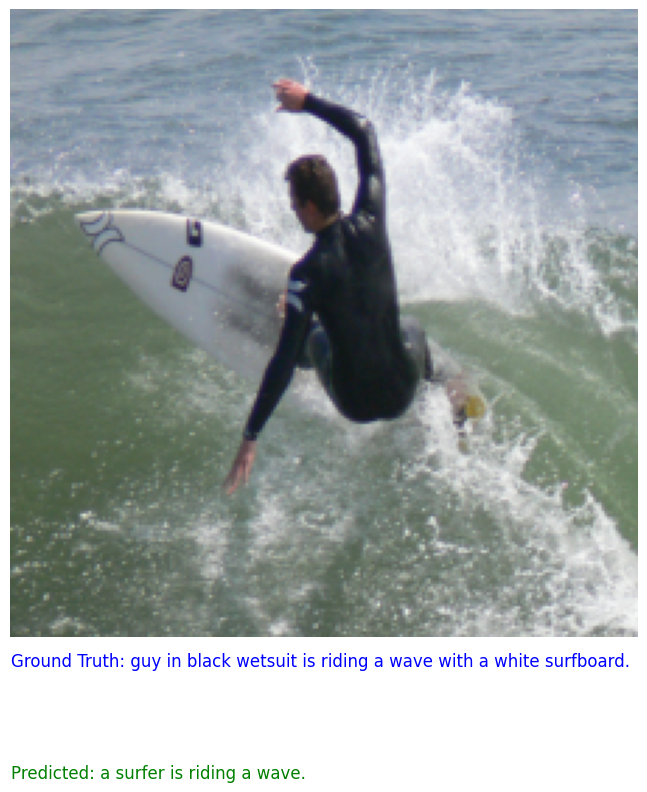

In [ ]:
visualize_random_prediction_color(encoder, decoder, val_loader, tokenizer, device)


In [ ]:
import json

# ✅ Your correct notebook name
notebook_path = '/content/My_Model(Advanced).ipynb'

# Load the notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = json.load(f)

# Remove 'widgets' from metadata if it exists
if 'widgets' in notebook.get('metadata', {}):
    print("🧹 Found 'widgets' metadata, removing...")
    del notebook['metadata']['widgets']
else:
    print("✅ No 'widgets' metadata found. No cleaning needed.")

# Save the cleaned notebook
with open(notebook_path, 'w', encoding='utf-8') as f:
    json.dump(notebook, f, indent=2)

print("✅ Notebook cleaned and saved successfully!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/My_Model(Advanced).ipynb'